In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from tensorflow.keras.applications import VGG16

In [2]:
# Load data
folder_path = r"C:\Users\padal\OneDrive\Desktop\my projects\Brain Tumour\archive\Brain_Tumor_Dataset"
negative_folder = 'Negative'
positive_folder = 'Positive'
negative_images = os.listdir(os.path.join(folder_path, negative_folder))
positive_images = os.listdir(os.path.join(folder_path, positive_folder))
dataset = []
labels = []

In [3]:
# Load 'Negative' images
for image_name in negative_images:
    image_path = os.path.join(folder_path, negative_folder, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset.append(image)
    labels.append(0)

In [4]:
# Load 'Positive' images
for image_name in positive_images:
    image_path = os.path.join(folder_path, positive_folder, image_name)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset.append(image)
    labels.append(1)

In [5]:

# Convert to NumPy arrays
X, y = np.array(dataset), np.array(labels)


In [6]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05, random_state=True)

In [7]:
# Data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1
)

In [8]:
# Load pre-trained VGG16 model
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the pre-trained weights

In [9]:
# Global average pooling layer
global_average_layer = GlobalAveragePooling2D()

In [10]:
# Prediction layer
prediction_layer = Dense(1, activation='sigmoid')

In [11]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [14]:
# Train the model with early stopping
history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=32),
                    epochs=15,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])

Epoch 1/15


157/157 [==============================] - 412s 3s/step - loss: 0.3359 - accuracy: 0.8804 - val_loss: 0.2695 - val_accuracy: 0.9280
Epoch 2/15
157/157 [==============================] - 399s 3s/step - loss: 0.1607 - accuracy: 0.9506 - val_loss: 0.1990 - val_accuracy: 0.9583
Epoch 3/15
157/157 [==============================] - 376s 2s/step - loss: 0.1327 - accuracy: 0.9576 - val_loss: 0.1618 - val_accuracy: 0.9621
Epoch 4/15
157/157 [==============================] - 416s 3s/step - loss: 0.1142 - accuracy: 0.9678 - val_loss: 0.1863 - val_accuracy: 0.9470
Epoch 5/15
157/157 [==============================] - 422s 3s/step - loss: 0.1049 - accuracy: 0.9672 - val_loss: 0.1249 - val_accuracy: 0.9621
Epoch 6/15
157/157 [==============================] - 432s 3s/step - loss: 0.0971 - accuracy: 0.9692 - val_loss: 0.1155 - val_accuracy: 0.9583
Epoch 7/15
157/157 [==============================] - 439s 3s/step - loss: 0.0819 - accuracy: 0.9732 - val_loss: 0.1360 - val_accuracy: 0.96

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

9/9 [==============================] - 21s 2s/step - loss: 0.0845 - accuracy: 0.9697
Test Loss: 0.08446192741394043
Test Accuracy: 0.9696969985961914


In [16]:
# Make predictions
predictions = model.predict(X_test)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, predicted_labels)
recall = recall_score(Y_test, predicted_labels)
f1 = f1_score(Y_test, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


9/9 [==============================] - 21s 2s/step
Precision: 0.9877300613496932
Recall: 0.9640718562874252
F1 Score: 0.9757575757575757


In [17]:
# Get the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


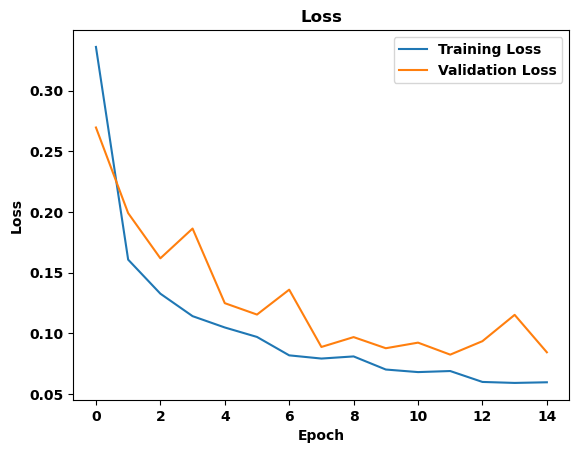

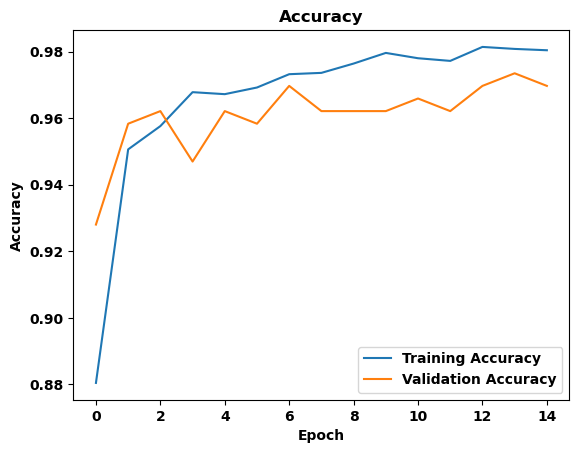

In [18]:
# Plot metrics
def plot_metrics(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss plot
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy plot
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)


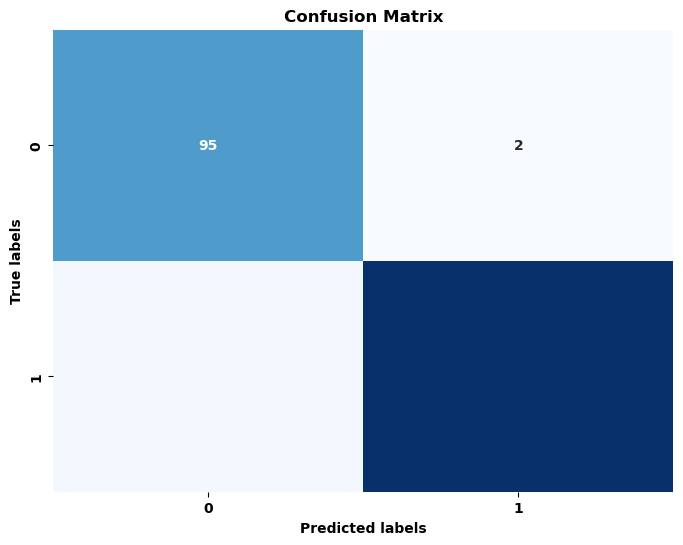

In [19]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(Y_test, predicted_labels)

In [20]:
# Additional evaluation metrics
# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, F1 score, and support
report = classification_report(Y_test, y_pred_binary)

# Calculate confusion matrix
cm = confusion_matrix(Y_test, y_pred_binary)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(Y_test, y_pred)

# Display classification report, confusion matrix, and ROC-AUC score
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)
print("\nROC-AUC Score:", roc_auc)

9/9 [==============================] - 20s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        97
           1       0.99      0.96      0.98       167

    accuracy                           0.97       264
   macro avg       0.96      0.97      0.97       264
weighted avg       0.97      0.97      0.97       264


Confusion Matrix:
[[ 95   2]
 [  6 161]]

ROC-AUC Score: 0.9967281930983394
